<a href="https://colab.research.google.com/github/bhushanmandava/PyTorch_fundamentals/blob/main/pytorch_NeuralNet_classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##intro
majority of the classification problems can be fit into two types

1.binary classification: spam or not spam | yes or no | pass or fail

2.multiclass Classification: dog , cat or person

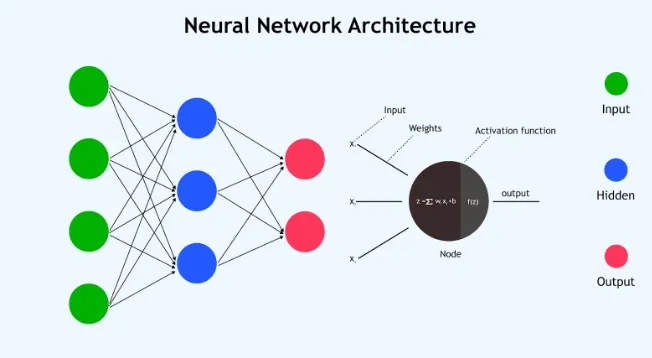

#neural net Arcitecture
* **green circles**: those are the features of our problem, usually columns in the table
* **blue circles**: hidden layers(for a deep net it will more than one layer comprise of consistent number of neurons in the each layer)
* **red circles**: output layer(for binary classification it will be one and for multicalssification it will be two)
* **neuron** : f(wi * xi + b) where w is the weight and b is the bias and f is the activation function(RELu or sigmoid or tanh )
* **Relu**: Most popular activation for the hidden layers
* **sigmoid** : most ppular activation of the output layer

In [1]:
from sklearn.datasets import make_circles
## creating the data set for our problem
n_samples = 1000
X , y = make_circles(n_samples , noise = 0.03, random_state = 42)

In [2]:
X.shape,y.shape# we have 2 features and 1 ground trouth

((1000, 2), (1000,))

In [3]:
# lets create a panda data frame for our data
import pandas as pd
df = pd.DataFrame(X,columns = ['x1','x2'])
df['y'] = y
df.head()

,x1,x2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [4]:
df.y.value_counts()# our split is 50 50

,count
y,
1,500
0,500


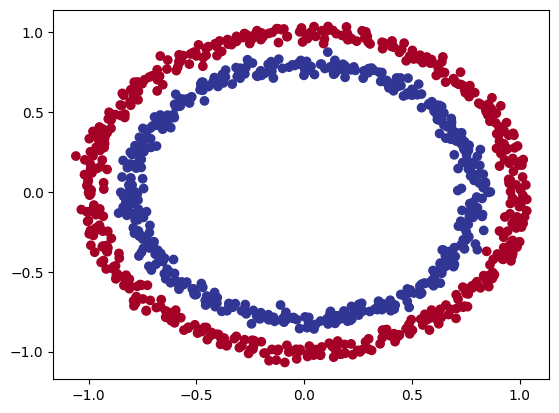

In [5]:
#vizuvalize the data set
import matplotlib.pyplot as plt
plt.scatter(df.x1,df.x2,c=y,cmap=plt.cm.RdYlBu)

#problem explainantion
we have binary classification problem at had we need top classify dots into red(0) and blue(1)
* infeatures : 2
* out features : 1

In [6]:
#step 1 preparing our data for the pytorch turning or numerical to tensors
import torch
X = torch.tensor(X,dtype=torch.float32)
y = torch.tensor(y,dtype=torch.float32)
X.shape,y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [7]:
# step 2 now we are spliting the dataset using train_test_split from sciket learn
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True ,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [8]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## things that we done so far
* we created our data set visuvalized it
* turned our problem into the classification problem
* split our data set into train and test(also shuffled it)
* instantiated the gpuµ\


In [9]:
#now creating the model class
class CircleClass(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(2,5)#infeatures 2 and out features 5(this number neurons present in our hidden layer)
    self.layer2 =nn.Linear(5,1)#hidden layer to out layer
  def forward(self,x):
    return self.layer2(self.layer1(x))
model = CircleClass().to(device)
model

CircleClass(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

## what are we missing
Activation layer.

In [10]:
#lets print the untrained predications
untrained_preds = model(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.1882],
        [-0.1385],
        [-0.4161],
        [-0.1232],
        [-0.5713],
        [-0.5398],
        [-0.2770],
        [-0.3713],
        [-0.4092],
        [-0.1369]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


as we can see our predication are very crude now lets train our model by setting up the loss and optimizer

In [11]:
loss_fn = nn.BCEWithLogitsLoss()#binary cross entropy with sigmoid built in
optimizer_fn = torch.optim.SGD(model.parameters(),lr=0.1)

## defing the evaluation metric
* loss funtion tell us how wrong our model is and Evaluation metrics tells us how good our model is

In [12]:
def accuracy_fn(y_true , y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [13]:
y_logits = model(X_test.to(device))
y_logits.shape# we got an added dimension and random numericals

torch.Size([200, 1])

Since our model hasn't been trained, these outputs are basically random.

But *what* are they?

They're the output of our `forward()` method.

Which implements two layers of `nn.Linear()` which internally calls the following equation:

$$
\mathbf{y} = x \cdot \mathbf{Weights}^T  + \mathbf{bias}
$$

The *raw outputs* (unmodified) of this equation ($y$) and in turn, the raw outputs of our model are often referred to as [**logits**](https://datascience.stackexchange.com/a/31045).

That's what our model is outputing above when it takes in the input data ($x$ in the equation or `X_test` in the code), logits.

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the [sigmoid activation function](https://pytorch.org/docs/stable/generated/torch.sigmoid.html).

Let's try it out.


In [14]:
# using the sigmoid activation for the logits to make sense
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4531],
        [0.4654],
        [0.3975],
        [0.4692],
        [0.3609],
        [0.3682],
        [0.4312],
        [0.4082],
        [0.3991],
        [0.4658],
        [0.4605],
        [0.4538],
        [0.4190],
        [0.3811],
        [0.4038],
        [0.3954],
        [0.4445],
        [0.4585],
        [0.4466],
        [0.4452],
        [0.4671],
        [0.3843],
        [0.4411],
        [0.4545],
        [0.4454],
        [0.4197],
        [0.3553],
        [0.3686],
        [0.4050],
        [0.3762],
        [0.4297],
        [0.4497],
        [0.4638],
        [0.3608],
        [0.4648],
        [0.4536],
        [0.4606],
        [0.3855],
        [0.3622],
        [0.3782],
        [0.4399],
        [0.4091],
        [0.4425],
        [0.3527],
        [0.4673],
        [0.4531],
        [0.3580],
        [0.4698],
        [0.4515],
        [0.3653],
        [0.4681],
        [0.4692],
        [0.3758],
        [0.3513],
        [0.4164],
        [0

if the probeblity if >0.5 then its belongs to class 1

else then it belongs to the class 0

In [15]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model(X_test.to(device))))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

In [16]:
## now building the training loop for our model
# start with the manual seed
torch.manual_seed(42)
epochs = 100
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model.train()
  y_logits = model(X_train).squeeze()#getting the logits and removin the extra dimension
  y_pred = torch.round(torch.sigmoid(y_logits))#turnig the logits into prob
  loss = loss_fn(y_logits,y_train)#getting the loss of our loggics
  acc = accuracy_fn(y_true = y_train,y_pred = y_pred)
  optimizer_fn.zero_grad()
  loss.backward()
  optimizer_fn.step()
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true = y_test,y_pred = test_pred)
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.71255 | Acc: 50.00% | Test Loss: 0.71433 | Test Acc: 50.00%
Epoch: 10 | Loss: 0.69918 | Acc: 43.88% | Test Loss: 0.70229 | Test Acc: 41.00%
Epoch: 20 | Loss: 0.69537 | Acc: 47.88% | Test Loss: 0.69867 | Test Acc: 48.00%
Epoch: 30 | Loss: 0.69425 | Acc: 49.50% | Test Loss: 0.69748 | Test Acc: 48.50%
Epoch: 40 | Loss: 0.69388 | Acc: 49.75% | Test Loss: 0.69700 | Test Acc: 49.50%
Epoch: 50 | Loss: 0.69372 | Acc: 50.12% | Test Loss: 0.69674 | Test Acc: 49.00%
Epoch: 60 | Loss: 0.69361 | Acc: 50.38% | Test Loss: 0.69655 | Test Acc: 48.00%
Epoch: 70 | Loss: 0.69354 | Acc: 50.88% | Test Loss: 0.69640 | Test Acc: 47.00%
Epoch: 80 | Loss: 0.69347 | Acc: 50.50% | Test Loss: 0.69627 | Test Acc: 47.50%
Epoch: 90 | Loss: 0.69342 | Acc: 50.62% | Test Loss: 0.69616 | Test Acc: 47.50%


Hmm, what do you notice about the performance of our model?

It looks like it went through the training and testing steps fine but the results don't seem to have moved too much.

The accuracy barely moves above 50% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).

from random import randbytes
## How to improve the model performance
* Add more Layers
* Add more hidden neurons
* play with more epochs
* try changing the learning rate
* try changing the loss function and optim function
* **ADD ACtivation function or chnage it** in the above model ve did not added any activation function so what happened our model is performing linearly

to inturduce the non leanirity we need activation(RELU most popular).

In [17]:
## build ing the new model again
class CircleClass_with_Activation(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(2,20)
    self.layer2 = nn.Linear(20,20)
    self.layer3 = nn.Linear(20,1)
    self.relu = nn.ReLU() # <- rectified linear unit for our non linearity
  def forward(self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
model = CircleClass_with_Activation()
model

CircleClass_with_Activation(
  (layer1): Linear(in_features=2, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)

In [18]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [19]:
# 1. Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Move model to device
model = model.to(device)

# 3. Move data to device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


In [20]:
#model training with not linearity
torch.manual_seed(42)
epochs = 1000
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)
for epoch in range(epochs):
  model.train()
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_pred=y_pred,y_true=y_train)
  optimizer_fn.zero_grad()
  loss.backward()
  optimizer_fn.step()
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true = y_test,y_pred = test_pred)
    if epoch%100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69448 | Acc: 47.62% | Test Loss: 0.69200 | Test Acc: 54.00%
Epoch: 100 | Loss: 0.69448 | Acc: 47.62% | Test Loss: 0.69200 | Test Acc: 54.00%
Epoch: 200 | Loss: 0.69448 | Acc: 47.62% | Test Loss: 0.69200 | Test Acc: 54.00%
Epoch: 300 | Loss: 0.69448 | Acc: 47.62% | Test Loss: 0.69200 | Test Acc: 54.00%
Epoch: 400 | Loss: 0.69448 | Acc: 47.62% | Test Loss: 0.69200 | Test Acc: 54.00%
Epoch: 500 | Loss: 0.69448 | Acc: 47.62% | Test Loss: 0.69200 | Test Acc: 54.00%
Epoch: 600 | Loss: 0.69448 | Acc: 47.62% | Test Loss: 0.69200 | Test Acc: 54.00%
Epoch: 700 | Loss: 0.69448 | Acc: 47.62% | Test Loss: 0.69200 | Test Acc: 54.00%
Epoch: 800 | Loss: 0.69448 | Acc: 47.62% | Test Loss: 0.69200 | Test Acc: 54.00%
Epoch: 900 | Loss: 0.69448 | Acc: 47.62% | Test Loss: 0.69200 | Test Acc: 54.00%


non linearity imporved the model but not too much  

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


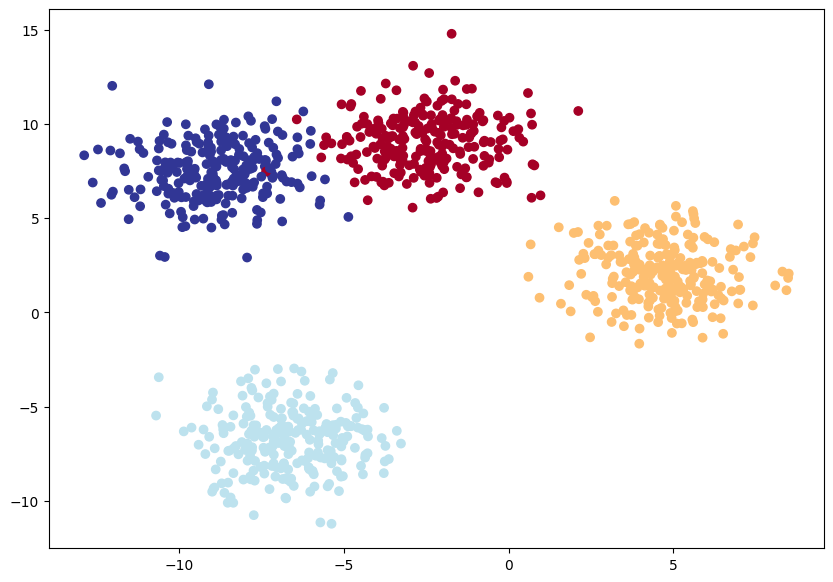

In [21]:
## lets do one multiclassification model
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [22]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
from torch import nn
class multiClass(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(2,8)
    self.layer2 = nn.Linear(8,8)
    self.layer3 = nn.Linear(8,4)
    self.relu = nn.ReLU()
  def forward(self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
model_mul = multiClass()
model_mul

multiClass(
  (layer1): Linear(in_features=2, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
)

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_mul.parameters(),lr=0.1)

In [27]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device
model_mul(X_blob_train)[:5]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], grad_fn=<SliceBackward0>)

In [29]:
# Make prediction logits with model
y_logits = model_mul(X_blob_test)

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], grad_fn=<SliceBackward0>)
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], grad_fn=<SliceBackward0>)


In [30]:
torch.sum(y_pred_probs[0])

tensor(1.0000, grad_fn=<SumBackward0>)

In [31]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3169, 0.3244, 0.1405, 0.2182], grad_fn=<SelectBackward0>)
tensor(1)


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mul = model_mul.to(device)

X_blob_train = X_blob_train.to(device)
y_blob_train = y_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_test = y_blob_test.to(device)


In [37]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device


for epoch in range(epochs):
    ### Training
    model_mul.train()

    # 1. Forward pass
    y_logits = model_mul(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_mul.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_mul(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


In [39]:
# Make predictions
model_mul.eval()
with torch.inference_mode():
    y_logits = model_mul(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [40]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%



These are some of the most common methods you'll come across and are a good starting point.

However, you may want to evaluate your classification model using more metrics such as the following:

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`torchmetrics.Accuracy()`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#id3) or [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`torchmetrics.Precision()`](https://torchmetrics.readthedocs.io/en/stable/classification/precision.html#id4) or [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`torchmetrics.Recall()`](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html#id5) or [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`torchmetrics.F1Score()`](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#f1score) or [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html#confusionmatrix) or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

Scikit-Learn (a popular and world-class machine learning library) has many implementations of the above metrics and you're looking for a PyTorch-like version, check out [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/), especially the [TorchMetrics classification section](https://torchmetrics.readthedocs.io/en/stable/pages/classification.html).


